WIND DOMINANT CASE

Remark: Difference of notations between this notebook and the article:

* "DG" stands for "DownGradient", scm_oce_dg is thus the 1D model for k-epsilon
* "DGNG" stands for "DownGradientNotGradient", scm_oce_dgng is thus the 1D model for ket
* "DGNG_test" is the ket model with sigma_varT = 10

PS: For a better readability of the Notebook, please install the "jupyter_contrib_nbextensions" and activate the "Collapsible Headings" + "Codefolding" extensions.

In [1]:
#### --------------------------------------------------------------------
#### If you want to run the notebook, please specify the following paths 
#### --------------------------------------------------------------------

path_to_Fortran_modules = '/toto1/'     # location of the Fortran modules (1D model)
path_to_LES_data = '/toto2/'            # location of LES results

# Imports

In [2]:
# ===================
#      Imports
# ===================
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import xarray as xr
import sys

sys.path.append(path_to_Fortran_modules + 'scm_oce_DG/')   
sys.path.append(path_to_Fortran_modules + 'scm_oce_DGNG/')
sys.path.append(path_to_Fortran_modules + 'scm_oce_DGNG_test/')
from scm_oce_DG import scm_oce_dg                 ### Fortran module for the 1D simulations
from scm_oce_DGNG import scm_oce_dgng             ### Fortran module for the 1D simulations
from scm_oce_DGNG_test import scm_oce_dgng_test

plt.rcParams['figure.figsize'] = (15,8)  #(6.8,4.5)
plt.rcParams.update({'font.size': 15})

# Functions

In [3]:
### Some calculations about MLD, rho, alpha, beta...

def rhoNL (T,S):
    """Calculation of the density through a non-linear equation of state
    T in °C and S in g/kg (PSU)"""
    QR=+999.842594  ; Q01=+6.793952e-2;  Q02=-9.095290e-3;  
    Q03=+1.001685e-4; Q04=-1.120083e-6;  Q05=+6.536332e-9;  
    Q10=+0.824493   ; Q11=-4.08990e-3 ;  Q12=+7.64380e-5;   
    Q13=-8.24670e-7 ; Q14=+5.38750e-9 ;  QS0=-5.72466e-3;   
    QS1=+1.02270e-4 ; QS2=-1.65460e-6 ;  Q20=+4.8314e-4;
    
    sqrtS   = np.sqrt(S)
    rho =   QR+T*(Q01+T*(Q02+T*(Q03+T*(Q04+T*Q05)))) \
             +S*(Q10+T*(Q11+T*(Q12+T*(Q13+T*Q14)))    \
             +sqrtS*(QS0+T*(QS1+T*QS2))+S*Q20)
    return(rho)

def alphaTS(T,S):
    """Calculation of the thermal expansion coefficient of the linear equation of state"""
    dT = 0.01
    alpha = 1/rhoNL(T,S) * (rhoNL(T,S) - rhoNL(T+dT,S))/dT
    return alpha

def betaTS(T,S):
    """Calculation of the haline contraction coefficient of the linear equation of state"""
    dS = 0.001
    beta = 1/rhoNL(T,S) * (rhoNL(T,S+dS) - rhoNL(T,S))/dS
    return beta

def glsMin(tke_min, eps_min, turbulence_scheme, stability_function):
    """Calculations of the minimal "psi" corresponding to the given minimal turbulent kinetic 
    energy and given minimal dissipation"""
    rp = rm = rn = 0.0        
    if   turbulence_scheme == 1:
        rp = -1.0 ; rm = 0.5  ; rn = -1.0
    elif turbulence_scheme == 2:
        rp = 3.0  ; rm = 1.5  ; rn = -1.0
    elif turbulence_scheme == 3:
        rp = 0.0  ; rm = 1.0  ; rn = -0.67 
    
    c1=5.; c2=0.8; c3=1.968; c4=1.136
    if   stability_function == 1:
        c1=3.6; c2=0.8;    c3=1.2;    c4=1.2
    elif stability_function == 2:
        c1=6.;  c2=0.32;   c3=0.;     c4=0.
    elif stability_function == 3:
        c1=6.;  c2=0.32;   c3=0.;     c4=0.
    elif stability_function == 4:
        c1=3.;  c2=0.8;    c3=2.;     c4=1.118
    elif stability_function == 5:
        c1=5.;  c2=0.6983; c3=1.9664; c4=1.094
    elif stability_function == 6:          
        c1=5.;  c2=0.7983; c3=1.968;  c4=1.136    

    nn  = 0.5*c1
    a1  = 0.66666666667-0.5*c2
    a2  = 1.-0.5*c3
    a3  = 1.-0.5*c4            
    cm0 =  pow( (a2*a2 - 3.0*a3*a3 + 3.0*a1*nn)/(3.0*nn*nn), 0.25 )     
    cff     = pow(cm0,3) * pow(tke_min,1.5) / eps_min                     
    gls_min = pow(cm0,rp) * pow(tke_min,rm) * pow(cff,rn) 
    return(gls_min)

# Parameters for the 1D simulations

In [4]:
#%%  INITIALISATION

#====================
# Input parameters
#====================

# Physical parameters ===========================================================
cp            = 4000.   # specific heat [J/kg/K] 
dpdx          = 0.      # barotropic pressure gradient [m/s2]
r_D           = 0.      # bottom friction  CD * ||ubot||
Zob           = 0.      # bottom rugosity length
Neu_bot       = True    # bottom boundary condition 
lin_eos       = False            # type of the equation of state
T0            = 20              # surface temperature of the initial profile [C]
S0            = 38              # constant salinity along the profile [psu]
alpha         = alphaTS(T0,S0)  # if lin_eos = True. Coef of the eos for the temperature [1/C]  
beta          = betaTS(T0,S0)   # if lin_eos = True. Coef of the eos for the salinity [1/psu]  
nuwm          = 1.0e-4          # minimal value of the turbulent viscosity 
nuws          = 0.1e-4          # minimal value of the turbulent diffusivity 
rho0          = rhoNL(T0,S0)    # reference density [kg/m3]
fcor          = 1e-4            # coriolis parameter [1/s]

### You need to fix N2 or dTdz0
N2            = 3e-6            # Brunt Vaisala frequency (diagnostic) [s-2]
dTdz0         = N2/9.81/alpha   # initial temperature gradient [C/m] 


# Spatial and temporal grids ====================================================
nz            = 256     # nb of vertical points
hmax          = 600.    # total depth of the domain [m] 
dt            = 360.    # time step [s]
dt_out        = 3600.      # output time step [s]
output_period = int(dt_out/dt)         # storage every x time steps
total_time    = 10*24*3600+1*3600             # total simulation time [s]
nb_steps      = int(total_time/dt)     # nb of time steps
ntra          = 2       # nb of tracers : 2 (temperature + salinity)
nt            = 2       # nb of time steps stored : 2 (n et n+1)
ngls          = 2       # nb of variable for GLS closure : 2 (TKE + GLS)  

In [5]:
#======================================================
#           Definition of the vertical grid
#======================================================
z_r    = np.zeros(nz)
z_w    = np.zeros(nz+1)
Hz     = np.zeros(nz)   
z_w[0] = -hmax
ds  = 1./nz
for k in range(nz,0,-1):
    sc_w     = ds * float(k-nz)
    z_w[k  ] = hmax*sc_w
    sc_r     = ds*(float(k-nz)-0.5)
    z_r[k-1] = hmax*sc_r
for k in range(nz):
    Hz[k] = z_w[k+1]-z_w[k]

In [6]:
#======================================================
#                Initial T,S profiles 
#======================================================
T_initial = np.zeros(nz); S_initial = np.zeros(nz)
for k in range(nz):
    T_initial[k] = T0 - dTdz0*np.abs(z_r[k])
    S_initial[k] = S0

In [7]:
ustar           = 2.0e-2                                # friction velocity [m/s]
tauy            = 0.                                    # meridional wind stress [N.m-2] 
tauy_m2s2       = tauy/rho0                             # meridional wind stress [m2/s2]
taux            = np.sqrt((ustar**2*rho0)**2 - tauy**2) # zonal wind stress [N.m-2] 
taux_m2s2       = taux/rho0                             # zonal wind stress [m2/s2] 

B0          = -5e-9                                     # buoyancy flux at the surface [m2/s3]  
EmP         = 0                                         # evaporation - precipitation [kg.m-2.s-1] = [mm.s-1]
freshflx    = EmP * S0 / rho0                           # fresh water flux (opposite of this flux to be precise) [psu.m/s]
fsol        = 0.                                        # solar flux [W/m^2]
fsol_Cms    = fsol / (rho0*cp)                          # solar flux [°C.m/s]
fnet   = (B0/9.81*rho0 + EmP * S0 * beta) * cp/alpha    # net heat fux [W/m2]
fnet_Cms = fnet / (rho0*cp)                             # net heat fux  [°C.m/s]
fnonsol = fnet - fsol                                   # non solar flux at the surface [W/m2]


# Performing the 1D simulations

In [8]:
#===============================================
# Initialisation of output variables
#===============================================

N_sch        = 5
# Number of schemes run
# Choose which ones at the end of the cell
    
n_sch        = -1                               # index of the current model
nout         = int((nb_steps-1)/output_period+1)  # nb of points stored
t_days       = np.zeros(nout)                   # output moments
T            = np.zeros((nz,nout,N_sch))        # T array
S            = np.zeros((nz,nout,N_sch))        # S array
varT         = np.zeros((nz+1,nout,N_sch))      # varT array
Kt           = np.zeros((nz+1,nout,N_sch))      # diffusion coeff for scalar
Gamma_GLS    = np.zeros((nz+1,nout,N_sch))      # "Possibly countergradient" part of the wT flux
wT_NL_KPP    = np.zeros((nz+1,nout))            # KPP non local flux for T
TKE          = np.zeros((nz+1,nout,N_sch))      # turbulent kinetic energy
Eps          = np.zeros((nz+1,nout,N_sch))      # dissip epsilon with eps(0) and eps(N) put to 0


### K-epsilon DG

In [9]:
# ===========    k-epsilon model    =================
    
ncount             = 0     # storage counter during the simulation
turbulence_scheme  = 2     # 0 KPP05, 1 K-omega, 2 K-eps, 3 gen, 4 KPP94, 5 TKE 
stability_function = 0     # only for GLS, "0" = Canuto A
Ric                = 0.3   # must be between 0.15 and 0.45
n_sch              = n_sch + 1
i_Keps_DG          = n_sch
EVD                = False   
NonLocalKPP        = True  # Not relevant here but needed to be given

# ===================================
# Initial condition definition
# ===================================

uoce  = np.zeros((nz,nt), order='F')       # initial u = 0
voce  = np.zeros((nz,nt), order='F')       # initial v = 0
toce  = np.zeros((nz,nt,ntra), order='F')  

for t in range(nt):
    toce[:,t,0] = T_initial    # initialisation of the temperature profile
    toce[:,t,1] = S_initial    # initialisation of the salinity profile
    
rho1  = np.zeros(nz)               # initialisation of the size of the density array
hbls  = np.array(0.)               # initialisation of the MLD
# Remark1: do not need to give the actual MLD since it is re-calculated before being used 
# Remark2: very important to give a one-element array and not a scalar, otherwise the Fortran routine
# cannot change it and hbls keep the same value during all the simulation...
    

# =========================================================
# Definition of a large scale forcing with a restoring time 
# delta. Ignored if delta = 0.
# =========================================================
unudge = np.zeros( nz )    # no geostrophic current u
vnudge = np.zeros( nz )    # no geostrophic current v
tnudge = np.zeros((nz,ntra), order='F')
delta  = np.zeros((nz,ntra), order='F')     

# bottom boundary condition for T and S
dTdz_bot     = np.zeros(ntra)
dTdz_bot[0]  = + dTdz0       # = the initial temperature vertical gradient [Celsius/m]
dTdz_bot[1]  = 0.            # no flux for the salinity [psu/m]


# =========================================================
# Initialisation of the parameters of the turbulent closure
# =========================================================

Akv  = np.zeros(nz+1)  
Akt  = np.zeros((nz+1,ntra), order='F')   
Akv [:]     = nuwm
Akt [:,0]   = nuws
Akt [:,1]   = nuws    
Akv [0] = Akv [nz] = 0.
Akt [0,0] = Akt [nz,0] = Akt [0,0] = Akt [nz,0] = 0.
wx_NL_KPP = np.zeros((nz+1,ntra), order='F')   

tke_min = 1.e-6
eps_min = 1.e-12
turb = np.zeros((nz+1,2,ntra), order='F')
turb[:,:,0] = tke_min
turb[:,:,1] = glsMin(tke_min, eps_min, turbulence_scheme, stability_function)
lmix = np.zeros(nz+1)
eps  = np.zeros(nz+1)
c_mu = np.zeros(nz+1)
c_mu_prime = np.zeros(nz+1)
alpha_n = np.zeros(nz+1)
alpha_m = np.zeros(nz+1)

#===============================================                   
# Temporal loop
#===============================================  

for kt in range(nb_steps):

    time = dt*float(kt)       # time in s

    nstp = 1 +  kt    % 2     # moment "n", = 1 or 2 (fortran index), python index = nstp-1 
    nnew = 1 + (kt+1) % 2     # # moment "n+1", = 1 or 2 (fortran index), python index = nnew-1
    check_inputs = False


    # temporal integration                                          
    scm_oce_dg.obl_stp_dg(z_r,z_w,Hz,                                     \
                    unudge,vnudge,tnudge,                                   \
                    uoce,voce,toce,turb,lmix,eps,                           \
                    rho0,rho1,Akv,Akt,wx_NL_KPP,c_mu,c_mu_prime,alpha_n,    \
                    alpha_m,r_D,taux_m2s2,tauy_m2s2,fsol_Cms,fnet_Cms,      \
                    freshflx,dTdz_bot,delta,fcor,Ric,hbls,                  \
                    dt,dpdx,turbulence_scheme,stability_function,           \
                    lin_eos,alpha,T0,beta,S0,Zob,Neu_bot,EVD,NonLocalKPP,   \
                    check_inputs,kt,nstp,nnew,nz,ntra,nt,ngls)
    
    time_nnew   = time + dt
    
    # if it is a storage moment
    if  kt % output_period == 0:
        t_days [ncount]      = time_nnew / (24. * 3600.)              # current time in day        
        Kt[:,ncount,n_sch]   = Akt[:,0]          # diffusivity storage
        T[:,ncount,n_sch]    = toce[:,nnew-1,0]  # temperature storage
        S[:,ncount,n_sch]    = toce[:,nnew-1,1]  # salinity storage
        
        TKE[:,ncount,n_sch]  = turb[:,nnew-1,0]  # TKE storage
        Eps[:,ncount,n_sch]  = eps               # dissipation storage
        ncount = ncount + 1      
        
#===============================================  
del uoce, voce, toce, turb, Akv, Akt   


 cm0      =   0.52646469697902432     
 alpha_n_min      =   -3.1426048370860973     
 alpha_m_max      =    34.823400336872986     
 keps_DG


### K-epsilon DGNG

In [10]:
# ===========    ket model    =================

ncount             = 0     # storage counter during the simulation
turbulence_scheme  = 2     # 0 KPP05, 1 K-omega, 2 K-eps, 3 gen, 4 KPP94, 5 TKE 
stability_function = 0     # only for GLS, "0" = Canuto A
Ric                = 0.3   # must be between 0.15 and 0.45
n_sch              = n_sch + 1
i_Keps_DGNG        = n_sch
EVD                = False   
NonLocalKPP        = True  # Not relevant here but needed to be given
printXinfo         = 0.
    
# ===================================
# Initial condition definition
# ===================================

uoce  = np.zeros((nz,nt), order='F')       # initial u = 0
voce  = np.zeros((nz,nt), order='F')       # initial v = 0
toce  = np.zeros((nz,nt,ntra), order='F') 
varToce  = np.zeros((nz+1,nt), order='F')  

for t in range(nt):
    toce[:,t,0] = T_initial    # initialisation of the temperature profile
    toce[:,t,1] = S_initial    # initialisation of the salinity profile
    
rho1  = np.zeros(nz)               # initialisation of the size of the density array
hbls  = np.array(0.)               # initialisation of the MLD
# Remark1: do not need to give the actual MLD since it is re-calculated before being used 
# Remark2: very important to give a one-element array and not a scalar, otherwise the Fortran routine
# cannot change it and hbls keep the same value during all the simulation...
    

# =========================================================
# Definition of a large scale forcing with a restoring time 
# delta. Ignored if delta = 0.
# =========================================================
unudge = np.zeros( nz )    # no geostrophic current u
vnudge = np.zeros( nz )    # no geostrophic current v
tnudge = np.zeros((nz,ntra), order='F')
delta  = np.zeros((nz,ntra), order='F')     

# bottom boundary condition for T and S
dTdz_bot     = np.zeros(ntra)
dTdz_bot[0]  = + dTdz0       # = the initial temperature vertical gradient [Celsius/m]
dTdz_bot[1]  = 0.            # no flux for the salinity [psu/m]


# =========================================================
# Initialisation of the parameters of the turbulent closure
# =========================================================

Akv  = np.zeros(nz+1)  
Akt  = np.zeros((nz+1,ntra), order='F')   
Akv [:]     = nuwm
Akt [:,0]   = nuws
Akt [:,1]   = nuws    
Akv [0] = Akv [nz] = 0.
Akt [0,0] = Akt [nz,0] = Akt [0,0] = Akt [nz,0] = 0.
wx_NL_KPP = np.zeros((nz+1,ntra), order='F')   
gamma_GLS = np.zeros((nz+1,ntra), order='F')   

tke_min = 1.e-6
eps_min = 1.e-12
turb = np.zeros((nz+1,2,ntra), order='F')
turb[:,:,0] = tke_min
turb[:,:,1] = glsMin(tke_min, eps_min, turbulence_scheme, stability_function)
lmix = np.zeros(nz+1)
eps  = np.zeros(nz+1)
c_mu = np.zeros(nz+1)
c_mu_prime = np.zeros(nz+1)
c_mu_prime_star = np.zeros(nz+1)
alpha_n = np.zeros(nz+1)
alpha_m = np.zeros(nz+1)
alpha_v = np.zeros(nz+1)

#===============================================                   
# Temporal loop
#===============================================  

for kt in range(nb_steps):

    time = dt*float(kt)       # time in s

    nstp = 1 +  kt    % 2     # moment "n", = 1 or 2 (fortran index), python index = nstp-1 
    nnew = 1 + (kt+1) % 2     # # moment "n+1", = 1 or 2 (fortran index), python index = nnew-1
    check_inputs = False

    # temporal integration                                          
    scm_oce_dgng.obl_stp_dgng(z_r,z_w,Hz,                      \
                    unudge,vnudge,tnudge,                                \
                    uoce,voce,toce,varToce,turb,lmix,eps,                \
                    rho0,rho1,Akv,Akt,gamma_GLS,wx_NL_KPP,c_mu,          \
                    c_mu_prime,c_mu_prime_star,                            \
                    alpha_n,alpha_m,alpha_v,r_D,                         \
                    taux_m2s2,tauy_m2s2,fsol_Cms,fnet_Cms,freshflx,      \
                    dTdz_bot,delta,fcor,Ric,hbls,                        \
                    dt,dpdx,turbulence_scheme,stability_function,        \
                    lin_eos,alpha,T0,beta,S0,Zob,Neu_bot,EVD,            \
                    NonLocalKPP,check_inputs,kt,nstp,nnew,nz,ntra,nt,ngls)

    # if it is a storage moment
    if  kt % output_period == 0:
        Kt[:,ncount,n_sch]         = Akt[:,0]          # diffusivity storage
        Gamma_GLS[:,ncount,n_sch]  = gamma_GLS[:,0]         
        T[:,ncount,n_sch]          = toce[:,nnew-1,0]  # temperature storage
        S[:,ncount,n_sch]          = toce[:,nnew-1,1]  # salinity storage
        varT[:,ncount,n_sch]       = varToce[:,nnew-1] # temperature variance storage
       
        TKE[:,ncount,n_sch]  = turb[:,nnew-1,0]  # TKE storage
        Eps[:,ncount,n_sch]  = eps               # dissipation storage
        ncount = ncount + 1      
        
#===============================================  
del uoce, voce, toce, turb, Akv, Akt      


 cm0              =   0.52646469697902432     
 alpha_n_min      =   -6.3750000000000009     
 alpha_m_max      =    34.823400375439398     
 keps_DGNG


### K-epsilon DGNG with sigma_varT = 10

In [11]:
# ===========  ket model with sigma_varT = 10  =================
    
ncount             = 0     # storage counter during the simulation
turbulence_scheme  = 2     # 0 KPP05, 1 K-omega, 2 K-eps, 3 gen, 4 KPP94, 5 TKE 
stability_function = 0     # only for GLS, "0" = Canuto A
Ric                = 0.3   # must be between 0.15 and 0.45
n_sch              = n_sch + 1
i_Keps_DGNG_test   = n_sch
EVD                = False   
NonLocalKPP        = True  # Not relevant here but needed to be given
count_condi        = np.zeros(10, dtype=np.int32)  # for counting conditions of alpha_v_min and alpha_v_max

# ===================================
# Initial condition definition
# ===================================

uoce  = np.zeros((nz,nt), order='F')       # initial u = 0
voce  = np.zeros((nz,nt), order='F')       # initial v = 0
toce  = np.zeros((nz,nt,ntra), order='F') 
varToce  = np.zeros((nz+1,nt), order='F')  

for t in range(nt):
    toce[:,t,0] = T_initial    # initialisation of the temperature profile
    toce[:,t,1] = S_initial    # initialisation of the salinity profile

rho1  = np.zeros(nz)               # initialisation of the size of the density array
hbls  = np.array(0.)               # initialisation of the MLD
# Remark1: do not need to give the actual MLD since it is re-calculated before being used 
# Remark2: very important to give a one-element array and not a scalar, otherwise the Fortran routine
# cannot change it and hbls keep the same value during all the simulation...


# =========================================================
# Definition of a large scale forcing with a restoring time 
# delta. Ignored if delta = 0.
# =========================================================
unudge = np.zeros( nz )    # no geostrophic current u
vnudge = np.zeros( nz )    # no geostrophic current v
tnudge = np.zeros((nz,ntra), order='F')
delta  = np.zeros((nz,ntra), order='F')     

# bottom boundary condition for T and S
dTdz_bot     = np.zeros(ntra)
dTdz_bot[0]  = + dTdz0       # = the initial temperature vertical gradient [Celsius/m]
dTdz_bot[1]  = 0.            # no flux for the salinity [psu/m]


# =========================================================
# Initialisation of the parameters of the turbulent closure
# =========================================================

Akv  = np.zeros(nz+1)  
Akt  = np.zeros((nz+1,ntra), order='F')   
Akv [:]     = nuwm
Akt [:,0]   = nuws
Akt [:,1]   = nuws    
Akv [0] = Akv [nz] = 0.
Akt [0,0] = Akt [nz,0] = Akt [0,0] = Akt [nz,0] = 0.
wx_NL_KPP = np.zeros((nz+1,ntra), order='F')   
gamma_GLS = np.zeros((nz+1,ntra), order='F')   

tke_min = 1.e-6
eps_min = 1.e-12
turb = np.zeros((nz+1,2,ntra), order='F')
turb[:,:,0] = tke_min
turb[:,:,1] = glsMin(tke_min, eps_min, turbulence_scheme, stability_function)
lmix = np.zeros(nz+1)
eps  = np.zeros(nz+1)
c_mu = np.zeros(nz+1)
c_mu_prime = np.zeros(nz+1)
c_mu_prime_star = np.zeros(nz+1)
alpha_n = np.zeros(nz+1)
alpha_m = np.zeros(nz+1)
alpha_v = np.zeros(nz+1)

#===============================================                   
# Temporal loop
#===============================================  

for kt in range(nb_steps):

    time = dt*float(kt)       # time in s

    nstp = 1 +  kt    % 2     # moment "n", = 1 or 2 (fortran index), python index = nstp-1 
    nnew = 1 + (kt+1) % 2     # # moment "n+1", = 1 or 2 (fortran index), python index = nnew-1
    check_inputs = False

    # temporal integration                                          
    scm_oce_dgng_test.obl_stp_dgng_test(z_r,z_w,Hz,                      \
                    unudge,vnudge,tnudge,                                \
                    uoce,voce,toce,varToce,turb,lmix,eps,                \
                    rho0,rho1,Akv,Akt,gamma_GLS,wx_NL_KPP,c_mu,          \
                    c_mu_prime,c_mu_prime_star,                            \
                    alpha_n,alpha_m,alpha_v,r_D,                         \
                    taux_m2s2,tauy_m2s2,fsol_Cms,fnet_Cms,freshflx,      \
                    dTdz_bot,delta,fcor,Ric,hbls,                        \
                    dt,dpdx,turbulence_scheme,stability_function,        \
                    lin_eos,alpha,T0,beta,S0,Zob,Neu_bot,EVD,            \
                    NonLocalKPP,check_inputs,kt,count_condi,nstp,nnew,nz,ntra,nt,ngls)

    # if it is a storage moment
    if  kt % output_period == 0:
        Kt[:,ncount,n_sch]         = Akt[:,0]          # diffusivity storage
        Gamma_GLS[:,ncount,n_sch]  = gamma_GLS[:,0]         
        T[:,ncount,n_sch]          = toce[:,nnew-1,0]  # temperature storage
        S[:,ncount,n_sch]          = toce[:,nnew-1,1]  # salinity storage
        varT[:,ncount,n_sch]       = varToce[:,nnew-1] # temperature variance storage

        TKE[:,ncount,n_sch]  = turb[:,nnew-1,0]  # TKE storage
        Eps[:,ncount,n_sch]  = eps               # dissipation storage
        ncount = ncount + 1      
    
#===============================================  
del uoce, voce, toce, turb, Akv, Akt      
    

 cm0              =   0.52646469697902432     
 alpha_n_min      =   -6.3750000000000009     
 alpha_m_max      =    34.823400375439398     
 keps_DGNG_test


### KPP

In [12]:
# ===========   KPP model   =================

    
ncount             = 0     # storage counter during the simulation
turbulence_scheme  = 4     # 0 KPP05, 1 K-omega, 2 K-eps, 3 gen, 4 KPP94, 5 TKE 
stability_function = 0     # only for GLS (1,2,3)
Ric                = 0.3   # must be between 0.15 and 0.45
n_sch              = n_sch + 1 
i_KPP              = n_sch
NonLocalKPP        = True    # Activation of the non-local term
EVD                = False   # Not relevant here but needed to be given
printXinfo         = 0.
    
# ===================================
# Initial condition definition
# ===================================

uoce  = np.zeros((nz,nt), order='F')       # initial u = 0
voce  = np.zeros((nz,nt), order='F')       # initial v = 0
toce  = np.zeros((nz,nt,ntra), order='F') 
varToce  = np.zeros((nz+1,nt), order='F')  

for t in range(nt):
    toce[:,t,0] = T_initial    # initialisation of the temperature profile
    toce[:,t,1] = S_initial    # initialisation of the salinity profile
    
rho1  = np.zeros(nz)               # initialisation of the size of the density array
hbls  = np.array(0.)               # initialisation of the MLD
# Remark1: do not need to give the actual MLD since it is re-calculated before being used 
# Remark2: very important to give a one-element array and not a scalar, otherwise the Fortran routine
# cannot change it and hbls keep the same value during all the simulation...
    

# =========================================================
# Definition of a large scale forcing with a restoring time 
# delta. Ignored if delta = 0.
# =========================================================
unudge = np.zeros( nz )    # no geostrophic current u
vnudge = np.zeros( nz )    # no geostrophic current v
tnudge = np.zeros((nz,ntra), order='F')
delta  = np.zeros((nz,ntra), order='F')     

# bottom boundary condition for T and S
dTdz_bot     = np.zeros(ntra)
dTdz_bot[0]  = + dTdz0       # = the initial temperature vertical gradient [Celsius/m]
dTdz_bot[1]  = 0.            # no flux for the salinity [psu/m]


# =========================================================
# Initialisation of the parameters of the turbulent closure
# =========================================================

Akv  = np.zeros(nz+1)  
Akt  = np.zeros((nz+1,ntra), order='F')   
Akv [:]     = nuwm
Akt [:,0]   = nuws
Akt [:,1]   = nuws    
Akv [0] = Akv [nz] = 0.
Akt [0,0] = Akt [nz,0] = Akt [0,0] = Akt [nz,0] = 0.
wx_NL_KPP = np.zeros((nz+1,ntra), order='F')   
gamma_GLS = np.zeros((nz+1,ntra), order='F')   

tke_min = 1.e-6
eps_min = 1.e-12
turb = np.zeros((nz+1,2,ntra), order='F')
turb[:,:,0] = tke_min
turb[:,:,1] = glsMin(tke_min, eps_min, turbulence_scheme, stability_function)
lmix = np.zeros(nz+1)
eps  = np.zeros(nz+1)
c_mu = np.zeros(nz+1)
c_mu_prime = np.zeros(nz+1)
c_mu_prime_star = np.zeros(nz+1)
alpha_n = np.zeros(nz+1)
alpha_m = np.zeros(nz+1)
alpha_v = np.zeros(nz+1)

#===============================================                   
# Temporal loop
#===============================================  

for kt in range(nb_steps):

    time = dt*float(kt)       # time in s

    nstp = 1 +  kt    % 2     # moment "n", = 1 or 2 (fortran index), python index = nstp-1 
    nnew = 1 + (kt+1) % 2     # # moment "n+1", = 1 or 2 (fortran index), python index = nnew-1
    check_inputs = False


    # temporal integration                                          
    scm_oce_dgng.obl_stp_dgng(z_r,z_w,Hz,                                \
                    unudge,vnudge,tnudge,                                \
                    uoce,voce,toce,varToce,turb,lmix,eps,                \
                    rho0,rho1,Akv,Akt,gamma_GLS,wx_NL_KPP,c_mu,          \
                    c_mu_prime,c_mu_prime_star,                          \
                    alpha_n,alpha_m,alpha_v,r_D,                         \
                    taux_m2s2,tauy_m2s2,fsol_Cms,fnet_Cms,freshflx,      \
                    dTdz_bot,delta,fcor,Ric,hbls,                        \
                    dt,dpdx,turbulence_scheme,stability_function,        \
                    lin_eos,alpha,T0,beta,S0,Zob,Neu_bot,EVD,            \
                    NonLocalKPP,check_inputs,kt,nstp,nnew,nz,ntra,nt,ngls)


    # if it is a storage moment
    if  kt % output_period == 0:
        Kt[:,ncount,n_sch]         = Akt[:,0]          # diffusivity storage
        
        wT_NL_KPP[:,ncount]        = wx_NL_KPP[:,0]    # non local flux for T storage
        
        Gamma_GLS[:,ncount,n_sch]  = gamma_GLS[:,0]         
        T[:,ncount,n_sch]          = toce[:,nnew-1,0]  # temperature storage
        S[:,ncount,n_sch]          = toce[:,nnew-1,1]  # salinity storage
        varT[:,ncount,n_sch]       = varToce[:,nnew-1] # temperature variance storage
        
        TKE[:,ncount,n_sch]  = turb[:,nnew-1,0]  # TKE storage
        Eps[:,ncount,n_sch]  = eps               # dissipation storage
        ncount = ncount + 1      
    
#===============================================  
del uoce, voce, toce, turb, Akv, Akt  


### KPP without NL

In [13]:
# ===========   KPP model without its non-local term   =================
    
ncount             = 0     # storage counter during the simulation
turbulence_scheme  = 4     # 0 KPP05, 1 K-omega, 2 K-eps, 3 gen, 4 KPP94, 5 TKE 
stability_function = 0     # only for GLS (1,2,3)
Ric                = 0.3   # must be between 0.15 and 0.45
n_sch              = n_sch + 1 
i_KPPwoNL          = n_sch
NonLocalKPP        = False    # Activation of the non-local term
EVD                = False   # Not relevant here but needed to be given
printXinfo         = 0.
    
# ===================================
# Initial condition definition
# ===================================

uoce  = np.zeros((nz,nt), order='F')       # initial u = 0
voce  = np.zeros((nz,nt), order='F')       # initial v = 0
toce  = np.zeros((nz,nt,ntra), order='F') 
varToce  = np.zeros((nz+1,nt), order='F')  

for t in range(nt):
    toce[:,t,0] = T_initial    # initialisation of the temperature profile
    toce[:,t,1] = S_initial    # initialisation of the salinity profile
    
rho1  = np.zeros(nz)               # initialisation of the size of the density array
hbls  = np.array(0.)               # initialisation of the MLD
# Remark1: do not need to give the actual MLD since it is re-calculated before being used 
# Remark2: very important to give a one-element array and not a scalar, otherwise the Fortran routine
# cannot change it and hbls keep the same value during all the simulation...
    

# =========================================================
# Definition of a large scale forcing with a restoring time 
# delta. Ignored if delta = 0.
# =========================================================
unudge = np.zeros( nz )    # no geostrophic current u
vnudge = np.zeros( nz )    # no geostrophic current v
tnudge = np.zeros((nz,ntra), order='F')
delta  = np.zeros((nz,ntra), order='F')     

# bottom boundary condition for T and S
dTdz_bot     = np.zeros(ntra)
dTdz_bot[0]  = + dTdz0       # = the initial temperature vertical gradient [Celsius/m]
dTdz_bot[1]  = 0.            # no flux for the salinity [psu/m]


# =========================================================
# Initialisation of the parameters of the turbulent closure
# =========================================================

Akv  = np.zeros(nz+1)  
Akt  = np.zeros((nz+1,ntra), order='F')   
Akv [:]     = nuwm
Akt [:,0]   = nuws
Akt [:,1]   = nuws    
Akv [0] = Akv [nz] = 0.
Akt [0,0] = Akt [nz,0] = Akt [0,0] = Akt [nz,0] = 0.
wx_NL_KPP = np.zeros((nz+1,ntra), order='F')   
gamma_GLS = np.zeros((nz+1,ntra), order='F')   

tke_min = 1.e-6
eps_min = 1.e-12
turb = np.zeros((nz+1,2,ntra), order='F')
turb[:,:,0] = tke_min
turb[:,:,1] = glsMin(tke_min, eps_min, turbulence_scheme, stability_function)
lmix = np.zeros(nz+1)
eps  = np.zeros(nz+1)
c_mu = np.zeros(nz+1)
c_mu_prime = np.zeros(nz+1)
c_mu_prime_star = np.zeros(nz+1)
alpha_n = np.zeros(nz+1)
alpha_m = np.zeros(nz+1)
alpha_v = np.zeros(nz+1)

#===============================================                   
# Temporal loop
#===============================================  

for kt in range(nb_steps):

    time = dt*float(kt)       # time in s

    nstp = 1 +  kt    % 2     # moment "n", = 1 or 2 (fortran index), python index = nstp-1 
    nnew = 1 + (kt+1) % 2     # # moment "n+1", = 1 or 2 (fortran index), python index = nnew-1
    check_inputs = False


    # temporal integration                                          
    scm_oce_dgng.obl_stp_dgng(z_r,z_w,Hz,                                \
                    unudge,vnudge,tnudge,                                \
                    uoce,voce,toce,varToce,turb,lmix,eps,                \
                    rho0,rho1,Akv,Akt,gamma_GLS,wx_NL_KPP,c_mu,          \
                    c_mu_prime,c_mu_prime_star,                          \
                    alpha_n,alpha_m,alpha_v,r_D,                         \
                    taux_m2s2,tauy_m2s2,fsol_Cms,fnet_Cms,freshflx,      \
                    dTdz_bot,delta,fcor,Ric,hbls,                        \
                    dt,dpdx,turbulence_scheme,stability_function,        \
                    lin_eos,alpha,T0,beta,S0,Zob,Neu_bot,EVD,            \
                    NonLocalKPP,check_inputs,kt,nstp,nnew,nz,ntra,nt,ngls)

    # if it is a storage moment
    if  kt % output_period == 0:
        Kt[:,ncount,n_sch]         = Akt[:,0]          # diffusivity storage
            
        Gamma_GLS[:,ncount,n_sch]  = gamma_GLS[:,0]         
        T[:,ncount,n_sch]          = toce[:,nnew-1,0]  # temperature storage
        S[:,ncount,n_sch]          = toce[:,nnew-1,1]  # salinity storage
        varT[:,ncount,n_sch]       = varToce[:,nnew-1] # temperature variance storage
            
        TKE[:,ncount,n_sch]  = turb[:,nnew-1,0]  # TKE storage
        Eps[:,ncount,n_sch]  = eps               # dissipation storage
        ncount = ncount + 1      

#===============================================  
del uoce, voce, toce, turb, Akv, Akt   


# Results and comparisons with the LES

In [14]:
dTdz = np.zeros((nz+1,nout,N_sch))
for s in range(N_sch):    
    for k in range(nz):
        dTdz[k,:,s] = (T[k,:,s] - T[k-1,:,s])/(z_r[k] - z_r[k-1])
        # Be careful, in Fortran, dTdz[k,:,s] = (T[k+1,:,s] - T[k,:,s])/(z_r[k+1] - z_r[k]) because the T
        # array is between 1 and N (instead of 0 and N-1 in Python), and the dTdz array between 0 and N. 
    dTdz[0,:,s] = dTdz[1,:,s]
    dTdz[-1,:,s] = dTdz[-2,:,s]
    
dSdz = np.zeros((nz+1,nout,N_sch))
for s in range(N_sch):    
    for k in range(nz):
        dSdz[k,:,s] = (S[k,:,s] - S[k-1,:,s])/(z_r[k] - z_r[k-1])
        # Be careful, in Fortran, dSdz[k,:,s] = (S[k+1,:,s] - S[k,:,s])/(z_r[k+1] - z_r[k]) because the S
        # array is between 1 and N (instead of 0 and N-1 in Python), and the dTdz array between 0 and N. 
    dSdz[0,:,s] = dSdz[1,:,s]
    dSdz[-1,:,s] = dSdz[-2,:,s]

    
wT_DG = - Kt * dTdz

wT_NG = np.zeros((nz+1,nout,N_sch))

wT_NG[:,:,i_KPP]       = wT_NL_KPP
wT_NG[:,:,i_Keps_DGNG] = Gamma_GLS[:,:,i_Keps_DGNG]
wT_NG[:,:,i_Keps_DGNG_test] = Gamma_GLS[:,:,i_Keps_DGNG_test]

wT = wT_DG + wT_NG
wS    = - Kt * dSdz
wb = 9.81 * (alpha * wT - beta * wS)


In [15]:
cT = 1.44
varT[:,:,i_Keps_DG] = cT * TKE[:,:,i_Keps_DG]/Eps[:,:,i_Keps_DG] * Kt[:,:,i_Keps_DG] * (dTdz[:,:,i_Keps_DG])**2
varT[0,:,i_Keps_DG] = varT[1,:,i_Keps_DG]
varT[-1,:,i_Keps_DG] = varT[-2,:,i_Keps_DG]
varT[-1,:,i_Keps_DGNG] = varT[-2,:,i_Keps_DGNG]


/tmp/ipykernel_1721569/1853268213.py:2: RuntimeWarning: divide by zero encountered in true_divide
  varT[:,:,i_Keps_DG] = cT * TKE[:,:,i_Keps_DG]/Eps[:,:,i_Keps_DG] * Kt[:,:,i_Keps_DG] * (dTdz[:,:,i_Keps_DG])**2
/tmp/ipykernel_1721569/1853268213.py:2: RuntimeWarning: invalid value encountered in multiply
  varT[:,:,i_Keps_DG] = cT * TKE[:,:,i_Keps_DG]/Eps[:,:,i_Keps_DG] * Kt[:,:,i_Keps_DG] * (dTdz[:,:,i_Keps_DG])**2


In [16]:
LES_dataset = xr.open_dataset(path_to_LES_data + 'LES_windDominant_results.nc').transpose()
# .transpose() => Same order as 1D-model outputs : depth, time
t_LES_seconds = LES_dataset.t
b_LES = LES_dataset.b
z_r_LES = LES_dataset.z
T_LES = T0 + b_LES/alpha/9.81
wb_LES = LES_dataset.wpbp
wT_LES = wb_LES/alpha/9.81
varT_LES = LES_dataset.bpbp /alpha**2/9.81**2

nz_LES = z_r_LES.size
nt_LES = t_LES_seconds.size
dTdz_LES = np.zeros((nz_LES+1,nt_LES))
z_w_LES = np.zeros((nz_LES+1))
dz_LES = z_r_LES[1] - z_r_LES[0]   # constant

for k in range(nz_LES):
    dTdz_LES[k,:] = (T_LES[k,:] - T_LES[k-1,:])/(z_r_LES[k] - z_r_LES[k-1])
    # Be careful, in Fortran, dTdz[k,:,s] = (T[k+1,:,s] - T[k,:,s])/(z_r[k+1] - z_r[k]) because the T
    # array is between 1 and N (instead of 0 and N-1 in Python), and the dTdz array between 0 and N. 
    z_w_LES[k] = (z_r_LES[k] + z_r_LES[k-1])/2
z_w_LES[0] = z_w_LES[1] - dz_LES
z_w_LES[-1] = z_w_LES[-2] + dz_LES
dTdz_LES[0,:] = dTdz_LES[1,:]
dTdz_LES[-1,:] = dTdz_LES[-2,:]


In [17]:
wb_KPP_temp = xr.DataArray(data=wb[:,:,i_KPP],dims=['z','t'])
zi_KPP_raw = z_w[wb_KPP_temp.argmin(axis=0).data]  
zi_KPP_raw[0] = -1
zi_KPP_raw[zi_KPP_raw == 0] = -1
t_seconds = t_days * 24 * 3600
X = np.log10(t_seconds[1:])
Y = np.log10(-zi_KPP_raw[1:])
p1_KPP = np.poly1d(np.polyfit(X[3:], Y[3:], 1))
zi_KPP = -10**p1_KPP[0]*t_seconds**p1_KPP[1]

wb_KPPwoNL_temp = xr.DataArray(data=wb[:,:,i_KPPwoNL],dims=['z','t'])
zi_KPPwoNL_raw = z_w[wb_KPPwoNL_temp.argmin(axis=0).data]  
zi_KPPwoNL_raw[0] = -1
zi_KPPwoNL_raw[zi_KPPwoNL_raw == 0] = -1
t_seconds = t_days * 24 * 3600
X = np.log10(t_seconds[1:])
Y = np.log10(-zi_KPPwoNL_raw[1:])
p1_KPPwoNL = np.poly1d(np.polyfit(X[3:], Y[3:], 1))
zi_KPPwoNL = -10**p1_KPPwoNL[0]*t_seconds**p1_KPPwoNL[1]


In [18]:
z_grad0_LES = z_w_LES[np.argmin(np.abs(dTdz_LES),axis=0)]    # close to z_r_LES[T_LES.argmax(axis=0)]
z_grad0_DG = z_w[np.argmin(np.abs(dTdz[:,:,i_Keps_DG]),axis=0)]
z_grad0_DGNG = z_w[np.argmin(np.abs(dTdz[:,:,i_Keps_DGNG]),axis=0)]
z_grad0_DGNG_test = z_w[np.argmin(np.abs(dTdz[:,:,i_Keps_DGNG_test]),axis=0)]
z_grad0_KPP = z_w[np.argmin(np.abs(dTdz[:,:,i_KPP]),axis=0)]
z_grad0_KPPwoNL = z_w[np.argmin(np.abs(dTdz[:,:,i_KPPwoNL]),axis=0)]


In [19]:
### ---------------------------------------------- ###
###     Defining max_varT for the normalization    ###
### ---------------------------------------------- ###
# Directly by taking the absolute maximum

max_varT_DG = z_w[np.argmax(varT[:,:,i_Keps_DG], axis = 0)]
max_varT_DGNG = z_w[np.argmax(varT[:,:,i_Keps_DGNG], axis = 0)]
max_varT_DGNG_test = z_w[np.argmax(varT[:,:,i_Keps_DGNG_test], axis = 0)]
max_varT_LES = z_w_LES[np.argmax(varT_LES[:,:].data, axis = 0)]


In [20]:
wstar_DG = (np.abs(B0 * max_varT_DG))**(1/3)
Tstar_DG = np.abs(fnet_Cms)/wstar_DG

wstar_DGNG = (np.abs(B0 * max_varT_DGNG))**(1/3)
Tstar_DGNG = np.abs(fnet_Cms)/wstar_DGNG

wstar_DGNG_test = (np.abs(B0 * max_varT_DGNG_test))**(1/3)
Tstar_DGNG_test = np.abs(fnet_Cms)/wstar_DGNG_test

wstar_KPP = (np.abs(B0 * zi_KPP))**(1/3)
Tstar_KPP = np.abs(fnet_Cms)/wstar_KPP

wstar_KPPwoNL = (np.abs(B0 * zi_KPPwoNL))**(1/3)
Tstar_KPPwoNL = np.abs(fnet_Cms)/wstar_KPPwoNL

max_varT_LES[max_varT_LES == 0] = -1
wstar_LES = (np.abs(B0 * max_varT_LES))**(1/3)
Tstar_LES = np.abs(fnet_Cms)/wstar_LES

# Figures Article

### Figure 7

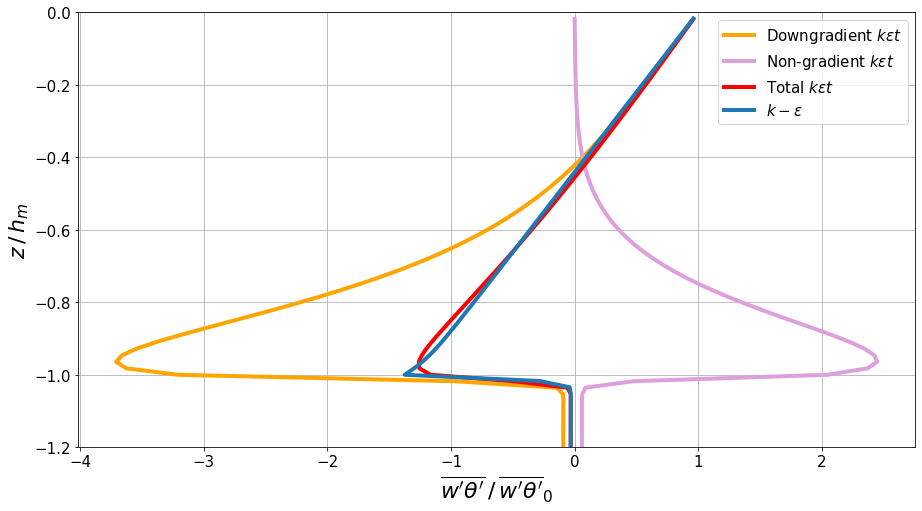

In [21]:
timeC=24*10
plt.plot(wT_DG[:-1,timeC,i_Keps_DGNG]/ -fnet_Cms,z_w[:-1]/-max_varT_DGNG[timeC],linewidth=4,color='orange',label=r'Downgradient $k \varepsilon t$')
plt.plot(wT_NG[:-1,timeC,i_Keps_DGNG]/ -fnet_Cms,z_w[:-1]/-max_varT_DGNG[timeC],linewidth=4,color='plum',label=r'Non-gradient $k \varepsilon t$')
plt.plot(wT[:-1,timeC,i_Keps_DGNG]/ -fnet_Cms,z_w[:-1]/-max_varT_DGNG[timeC],linewidth=4,color='red',label=r'Total $k \varepsilon t$')
plt.plot(wT[:-1,timeC,i_Keps_DG]/ -fnet_Cms,z_w[:-1]/-max_varT_DG[timeC],color='tab:blue',linewidth=4,label=r"$k-\varepsilon$")

plt.ylim(-1.2,0)
plt.grid()
plt.xlabel(r"$\overline{w' \theta'} \, / \, \overline{w' \theta'}_0$", fontsize = 22)
plt.ylabel(r"$ z \, / \, h_m$", fontsize = 22)
plt.legend()


### Figure 8

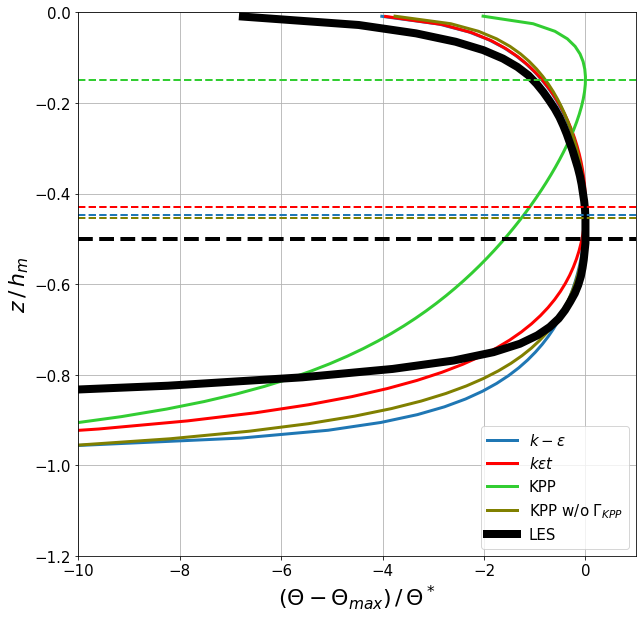

In [22]:
timeC=24*10
plt.figure(figsize=(10,10))
plt.plot( (T[:,timeC,i_Keps_DG]-np.max(T[:,timeC,i_Keps_DG]))/Tstar_DG[timeC] ,z_r/-max_varT_DG[timeC],color='tab:blue',linewidth=3,label=r"$k-\varepsilon$")
plt.plot( (T[:,timeC,i_Keps_DGNG]-np.max(T[:,timeC,i_Keps_DGNG]))/Tstar_DGNG[timeC] ,z_r/-max_varT_DGNG[timeC],color='red',linewidth=3,label=r'$k \varepsilon t$')

plt.plot( (T[:,timeC,i_KPP]-np.max(T[:,timeC,i_KPP]))/Tstar_KPP[timeC] ,z_r/-zi_KPP[timeC],color='limegreen',linewidth=3,label='KPP')
plt.plot( (T[:,timeC,i_KPPwoNL]-np.max(T[:,timeC,i_KPPwoNL]))/Tstar_KPPwoNL[timeC] ,z_r/-zi_KPPwoNL[timeC],color='olive',linewidth=3,label=r'KPP w/o $\Gamma_{KPP}$')
plt.plot( (T_LES[:,timeC]-np.max(T_LES[:,timeC]))/Tstar_LES[timeC] ,z_r_LES/-max_varT_LES[timeC],linewidth=8,color='black',label='LES')


plt.ylim(-1.2,0)
plt.xlim(-10,1)

#plt.axvline(x=0, linestyle='--', color='silver',linewidth=2)

plt.axhline(y=z_grad0_DG[timeC]/-max_varT_DG[timeC], linestyle='--', color='tab:blue',linewidth=2)
plt.axhline(y=z_grad0_DGNG[timeC]/-max_varT_DGNG[timeC], linestyle='--', color='red',linewidth=2)
plt.axhline(y=z_grad0_KPP[timeC]/-zi_KPP[timeC], linestyle='--', color='limegreen',linewidth=2)
plt.axhline(y=z_grad0_KPPwoNL[timeC]/-zi_KPPwoNL[timeC]-0.004, linestyle='--', color='olive',linewidth=2)  # small shift just for seeing the line
plt.axhline(y=z_grad0_LES[timeC]/-max_varT_LES[timeC], linestyle='--', color='black',linewidth=4)

plt.xlabel(r"$(\Theta - \Theta_{max}) \, / \, \Theta^*$", fontsize = 22)
plt.ylabel(r"$ z \, / \, h_m$", fontsize = 22)
plt.legend()
plt.grid()


### Figure 9

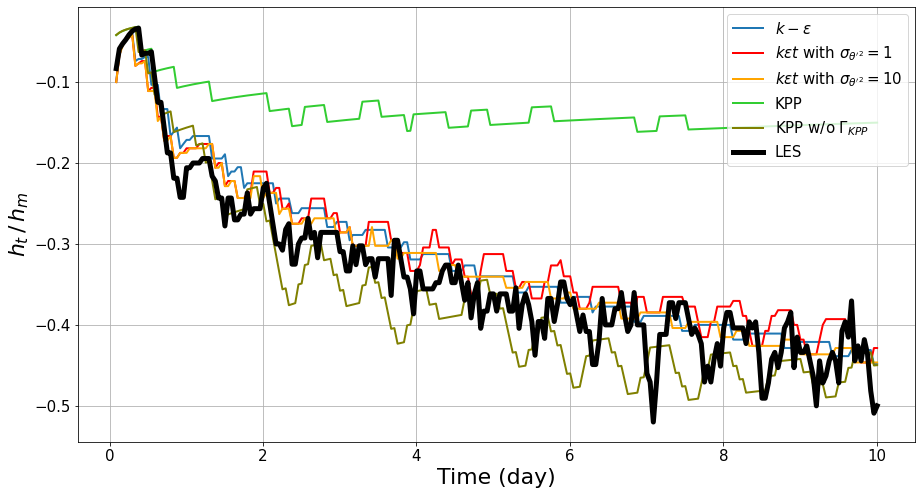

In [23]:
plt.plot(t_days[2:], z_grad0_DG[2:]/-max_varT_DG[2:],linewidth=2,color='tab:blue', label=r"$k-\varepsilon$")
plt.plot(t_days[2:], z_grad0_DGNG[2:]/-max_varT_DGNG[2:],linewidth=2,color='red', label=r"$k \varepsilon t$ with $\sigma_{\theta'^2} = 1$")
plt.plot(t_days[2:], z_grad0_DGNG_test[2:]/-max_varT_DGNG_test[2:],linewidth=2,color='orange', label=r"$k \varepsilon t$ with $\sigma_{\theta'^2} = 10$")
plt.plot(t_days[2:], z_grad0_KPP[2:]/-zi_KPP[2:],linewidth=2,color='limegreen', label='KPP')
plt.plot(t_days[2:], z_grad0_KPPwoNL[2:]/-zi_KPPwoNL[2:],linewidth=2,color='olive', label=r'KPP w/o $\Gamma_{KPP}$')
plt.plot(t_days[2:], z_grad0_LES[2:]/-max_varT_LES[2:],linewidth=5,color='black', label='LES')
plt.xlabel('Time (day)', fontsize = 22)
plt.ylabel(r"$h_t \, / \, h_m$", fontsize = 22)
plt.grid()
plt.legend(loc='upper right')


### Figure 10

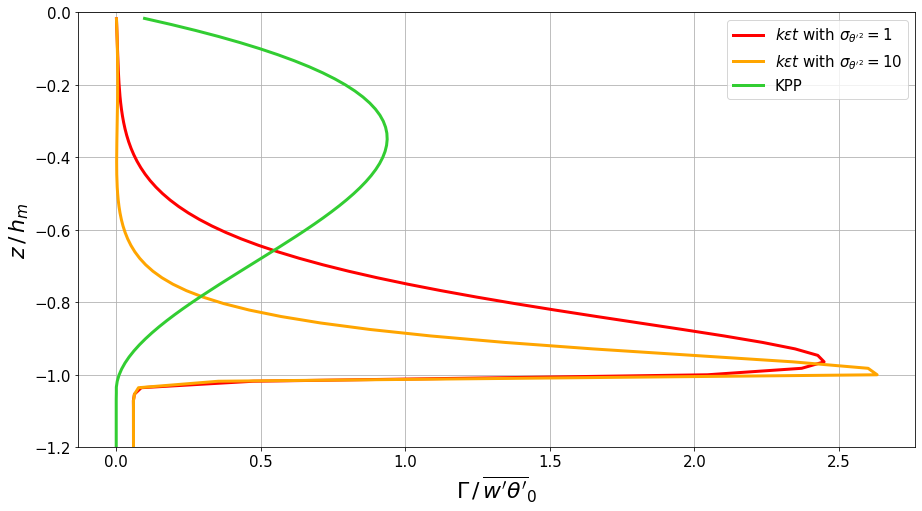

In [24]:
timeC=24*10
plt.plot(wT_NG[:-1,timeC,i_Keps_DGNG]/ -fnet_Cms,z_w[:-1]/-max_varT_DGNG[timeC],color='red',linewidth=3,label=r"$k \varepsilon t$ with $\sigma_{\theta'^2} = 1$")
plt.plot(wT_NG[:-1,timeC,i_Keps_DGNG_test]/ -fnet_Cms,z_w[:-1]/-max_varT_DGNG_test[timeC],color='orange',linewidth=3,label=r"$k \varepsilon t$ with $\sigma_{\theta'^2} = 10$")
plt.plot(wT_NG[:-1,timeC,i_KPP]/ -fnet_Cms,z_w[:-1]/-zi_KPP[timeC],color='limegreen',linewidth=3,label='KPP')

plt.ylim(-1.2,0)

plt.xlabel(r"$\Gamma \, / \, \overline{w' \theta'}_0$", fontsize = 22)
plt.ylabel(r"$ z \, / \, h_m$", fontsize = 22)
plt.grid()
plt.legend()
